# Packages and function

In [13]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import functions required for processing of the FRS data
import frsprocessing as frs
import SpectralData as SD

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Input/Output

In [14]:
# import and load FRS traces
metafile = pd.read_excel(r"data\ISA1 raw data\FRSMetaInfoSet.xlsx", sheet_name='FRSMetaInfoSet', converters={'sample_name':str}) # read metafile
t_raw = np.load(r'data\ISA1 raw data\t_raw.npy')
td_ref_raw = np.load(r'data\ISA1 raw data\td_ref_raw.npy')
td_sam_raw = np.load(r'data\ISA1 raw data\td_sam_raw.npy')

t, td_ref,td_sam, freq, hc = frs.frs_fft(t_raw,td_ref_raw,td_sam_raw)
# store spectra in class object for handling, processing, and analysing spectral data
Data =  SD.SpectralData(freq, hc, data_type='hc')
Data.backup()

# Fig 4a,b

(Text(0, 0.5, 'EOS (a.u.)'), Text(0.5, 0, 'Time (fs)'))

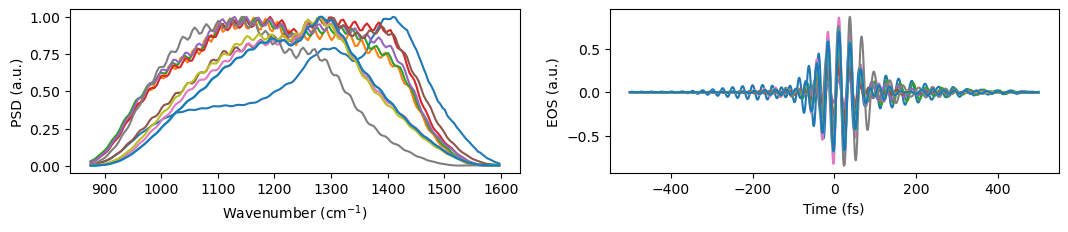

In [15]:
idx_f1, idx_f2 = (np.abs(freq - 875)).argmin(), (np.abs(freq - 1600)).argmin() # set limits of the filter in wavenumbers
idx_t1, idx_t2 = (np.abs(t - -500)).argmin(), (np.abs(t - 500)).argmin() # set limits of the filter in wavenumbers

### plotting - average td-trace and pulse spectrum for each measuremnt day ###
fig, ax = plt.subplots(1,2, figsize= (18*1.8/2.54,3*1.8/2.54))
for seq in metafile["sequence ID"].unique():
    index = metafile[(metafile["sequence ID"] == seq)].index.to_numpy()
    td_ref_mean = np.mean(td_ref[index,:], axis=0)
    FD_mean = np.abs(np.fft.rfft(td_ref_mean))[idx_f1:idx_f2]
    ax[0].plot(freq[idx_f1:idx_f2], FD_mean/FD_mean.max(), label = str(seq))
    ax[1].plot(t[idx_t1:idx_t2],td_ref_mean[idx_t1:idx_t2])

ax[0].set_ylabel('PSD (a.u.)'), ax[0].set_xlabel('Wavenumber (cm$^{-1}$)')
ax[1].set_ylabel('EOS (a.u.)'), ax[1].set_xlabel('Time (fs)')

## c-e) comparison of the different approaches

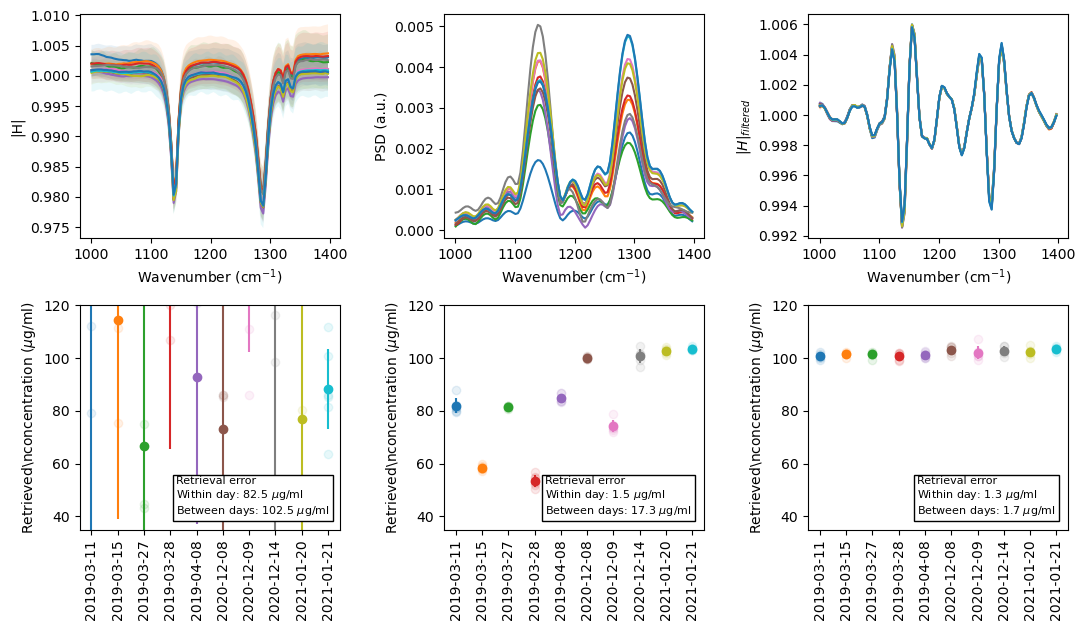

In [16]:
# calculate the referenced sample response from the raw td-data
t, td_ref,td_sam, freq, hc = frs.frs_fft(t_raw,td_ref_raw,td_sam_raw)
Data = SD.SpectralData(freq, hc, data_type='hc').backup()
  
f1, f2 = 1000, 1400 # limits of the applied Tukey filter in the FD
t1, t2 = 550, 1450 # limits of the applied Tukey filter in the td

### pre-processing ###
hc = Data.data # non-processed data

# time-filtering
Data.loadbackup()

Data.tdf(t1, t2=t2,w_f=SD.tukeyF(freq,f1,f2,25)) # apply time-domain filtering
hc_tdf = Data.data # time-filtered data
hc, hc_tdf, corr = frs.pathlengthcorrection(metafile,hc, hc_tdf,idx_f1,idx_f2,1667) # take into account that different experiments were performed with different pathlengths and correct for it
td_diff, fdc_diff = frs.calc_diff(metafile,td_ref, td_sam, t, t1, t2, 50, corr=corr) # calculate time-domain difference traces

idx_f1, idx_f2 = (np.abs(freq - 1000)).argmin(), (np.abs(freq - 1400)).argmin() # set the plot range

### plotting ###
fig, ax = plt.subplots(2,3, figsize= (18*1.8/2.54,10*1.7/2.54))
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.4)
ax = ax.ravel()

### spectral reproducibility
filter_conc = metafile["Conc [ug/ml]"] == 1000 # select  concentration
for seq in metafile["sequence ID"].unique():
    index = metafile[(metafile["sequence ID"] == seq) & filter_conc].index.to_numpy()
    if index.size == 0:
        continue
    
    # standard processing
    mu    = np.mean(np.abs(hc[index,idx_f1:idx_f2]), axis=0)
    sigma = np.std(np.abs(hc[index,idx_f1:idx_f2]), axis=0)
    ax[0].plot(freq[idx_f1:idx_f2],mu)
    ax[0].fill_between(freq[idx_f1:idx_f2], mu+sigma, mu-sigma, alpha=0.1)     
    # td differences    
    mu    = np.mean(np.abs(fdc_diff[index,idx_f1:idx_f2]), axis=0)
    sigma = np.std(np.abs(fdc_diff[index,idx_f1:idx_f2]), axis=0)
    ax[1].plot(freq[idx_f1:idx_f2],mu)
    ax[1].fill_between(freq[idx_f1:idx_f2], mu+sigma, mu-sigma, alpha=0.1)
    # Time-domain filtering
    mu   = np.mean(np.abs(hc_tdf[index,idx_f1:idx_f2]), axis=0)
    sigma = np.std(np.abs(hc_tdf[index,idx_f1:idx_f2]), axis=0)
    ax[2].plot(freq[idx_f1:idx_f2],mu)
    ax[2].fill_between(freq[idx_f1:idx_f2], mu+sigma, mu-sigma, alpha=0.1)

### concentration retrieval ###
# use all 1000 ug/ml measurements from a specific measurement day for calibration
index = metafile[(metafile["sequence ID"] == 1667) & (metafile["Conc [ug/ml]"] == 1000.0)].index.to_numpy()
# calc calibration spectra
hc_Fit = np.mean(hc[index,:], axis=0)
fdc_diff_Fit = np.mean(fdc_diff[index,:]+1, axis=0)
hc_tdf_Fit = np.mean(hc_tdf[index,:], axis=0)

# loop through all measurment days and collect spectra and retrieved concentrations
filter_conc = metafile["Conc [ug/ml]"] == 100 # concentration to analyze
mu1_seq, mu2_seq, mu3_seq = [],[],[] # empty arrays to collect mean retrieved concentration of each measurement day
sigma1_seq, sigma2_seq, sigma3_seq = [],[],[] # empty arrays to collect retrieval error of each measurement day
c1_all, c2_all, c3_all = [],[],[] # empty arrays to collect all retrieved concentrations
dates = [] # empty array to collect the  analysed measurement days
for j, seq in enumerate(metafile["date"].unique()): # loop over measuement days
    index = metafile[(metafile["date"] == seq) & filter_conc].index.to_numpy()
    if index.size == 0:
        continue
    dates.append(seq.to_numpy())
    c1, c2, c3 = [],[],[]
    for k in index: # loop over individual measurements to collect retrieved concentratons
        c = frs.concdot(hc[k],hc_Fit,idx_f1,idx_f2)
        c1.append(c*1000)
        c1_all.append(c*1000)
        c = frs.concdot(fdc_diff[k]+1,fdc_diff_Fit,idx_f1,idx_f2)
        c2.append(c*1000)
        c2_all.append(c*1000)
        c = frs.concdot(hc_tdf[k],hc_tdf_Fit,idx_f1,idx_f2)
        c3.append(c*1000)
        c3_all.append(c*1000)
    mu1, mu2, mu3    = np.mean(c1), np.mean(c2), np.mean(c3)
    sigma1, sigma2, sigma3 = np.std(c1), np.std(c2), np.std(c3)
    mu1_seq.append(mu1), mu2_seq.append(mu2), mu3_seq.append(mu3)
    sigma1_seq.append(sigma1), sigma2_seq.append(sigma2), sigma3_seq.append(sigma3)
    ax[3].errorbar(j, mu1, yerr=sigma1, fmt='o')
    ax[3].scatter(j*np.ones(len(c1)),np.array(c1), alpha=0.1)
    ax[4].errorbar(j, mu2, yerr=sigma2, fmt='o')
    ax[4].scatter(j*np.ones(len(c2)),np.array(c2), alpha=0.1)
    ax[5].errorbar(j, mu3, yerr=sigma3, fmt='o')
    ax[5].scatter(j*np.ones(len(c3)),np.array(c3), alpha=0.1)

ax[0].set_ylabel('|H|'), ax[1].set_ylabel('PSD (a.u.)'), ax[2].set_ylabel('$|H|_{filtered}$')  
for i in range(3):
    ax[i+3].set_ylim(35,120)
    ax[i+3].set_xticks(range(1,len(dates)+1))
    ax[i+3].set_xticklabels(np.datetime_as_string(dates, 'D'), rotation=90)
    ax[i].set_xlabel('Wavenumber (cm$^{-1}$)')
    ax[i+3].set_ylabel(r'Retrieved\nconcentration ($\mu$g/ml)')#, ax[i+3].set_xlabel('measurement day')
    
if 1:
    props = dict(boxstyle='square', facecolor='white')
    ax[3].text(0.37, 0.07, '\n'.join((r'Retrieval error',
    r'Within day: %.1f $\mu$g/ml' % (np.mean(sigma1_seq), ),
    r'Between days: %.1f $\mu$g/ml' % (np.std(c1_all), ))), transform=ax[3].transAxes, fontsize=8, bbox=props, ha="left")
    ax[4].text(0.39, 0.07, '\n'.join((r'Retrieval error',
    r'Within day: %.1f $\mu$g/ml' % (np.mean(sigma2_seq), ),
    r'Between days: %.1f $\mu$g/ml' % (np.std(c2_all), ))), transform=ax[4].transAxes, fontsize=8, bbox=props, ha="left")
    ax[5].text(0.42, 0.07, '\n'.join((r'Retrieval error',
    r'Within day: %.1f $\mu$g/ml' % (np.mean(sigma3_seq), ),
    r'Between days: %.1f $\mu$g/ml' % (np.std(c3_all), ))), transform=ax[5].transAxes, fontsize=8, bbox=props, ha="left")

plt.subplots_adjust(hspace=0.3)

# Fig 3

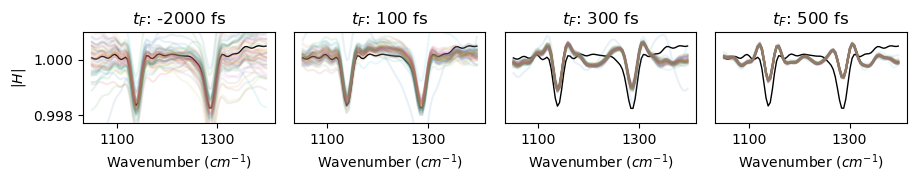

In [17]:
t, td_ref,td_sam, freq, hc = frs.frs_fft(t_raw,td_ref_raw,td_sam_raw, noecho=True) # cut out the pulse echo in the original td trace to remove oscillations in the sample transfer function

Data =  SD.SpectralData(freq, hc, data_type='hc') # create spectral dataset object
idx_f1, idx_f2 = (np.abs(freq - 1050)).argmin(), (np.abs(freq - 1400)).argmin() # set plot/evalution range

times =  [-2000, 100, 300, 500] # cut-off times for the time-domain filter
index  = metafile[metafile["Conc [ug/ml]"] == 100.0].index.to_numpy() # selected DMSO2 concentration

fig, axs = plt.subplots(1, 4, figsize= (18*1.5/2.54,3/2.54)) # 
for i, ax in enumerate(axs.flat): # loop through all subplots/cut-off times
        Data.tdf(times[i],w_f=SD.tukeyF(freq,950,1450,25)) # apply time-domain filtering
        hc_tdf = Data.data
        _, hc_tdf, _ = frs.pathlengthcorrection(metafile,hc, hc_tdf,idx_f1,idx_f2,1667) # take into account that different experiments were performed with different pathlengths and correct for it
        ax.plot(freq[idx_f1:idx_f2],np.mean(np.abs(hc[index,idx_f1:idx_f2]),axis=0), 'k', alpha=1, lw=1)
        ax.plot(freq[None,idx_f1:idx_f2].T,np.abs(hc_tdf[index,idx_f1:idx_f2]).T, alpha=0.1)
        ax.set_title('$t_F$: '+str(times[i]) +' fs')
        ax.set_xlabel("Wavenumber ($cm^{-1}$)")
        ax.set_ylim(0.9977,1.001)
        ax.set_xticks([1100,1300])
        if i:
                ax.set_yticks([])
                
axs[0].set_ylabel("$|H|$")
plt.subplots_adjust(wspace=0.1)

## SNR vs $t_F$

650

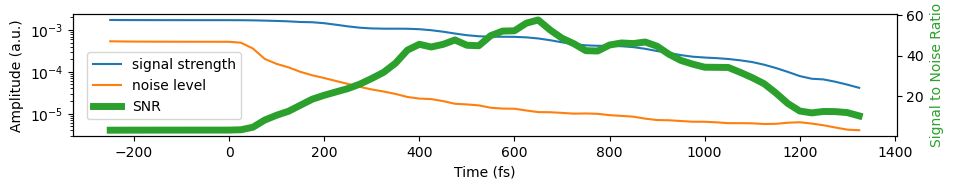

In [18]:
idx_f1, idx_f2 = (np.abs(freq - 1050)).argmin(), (np.abs(freq - 1400)).argmin() # set plot/evalution range

### load the data ###
t, td_ref,td_sam, freq, hc = frs.frs_fft(t_raw,td_ref_raw,td_sam_raw, noecho=True) # cut out the pulse echo in the original td trace to remove oscillationsin the sample transfer function
Data =  SD.SpectralData(freq, hc, data_type='hc') # create spectral dataset object

s, n = [],[] #empty arrays to collect signal and noise for different onset of the time-filter
times = [i for i in range(-250,1350,25)]
for t1 in times: # loop through values for the onset of the time-filter
    Data.tdf(t1,w_f=SD.tukeyF(freq,1000,1400,50)) #apply time-domain filtering
    hc_tdf = Data.data
    hc,hc_tdf, _ = frs.pathlengthcorrection(metafile,hc,hc_tdf,idx_f1,idx_f2,1667) # take into account that different experiments were performed with different pathlengths and correct for it
    
    # collect the signal strength values
    index  = metafile[metafile["Conc [ug/ml]"] == 100.0].index.to_numpy()
    mu_100 = np.mean(np.abs(hc_tdf[index,idx_f1:idx_f2]), axis=0)
    s.append(np.abs(mu_100-1).max())
    
    # collect noise values - Note: no pure water to water references were measured. since 0.1 ug/ml is well below the detection limit, this is a good approximation for it #
    index  = metafile[metafile["Conc [ug/ml]"] == 0.1].index.to_numpy()
    n.append(np.std(np.abs(hc_tdf[index,idx_f1:idx_f2]), axis=0).mean())
s = np.array(s) # signal strength
n = np.array(n) # noise level   
snr = s/n # signal to noise ratio

fig, ax1 = plt.subplots(1, figsize= (18*1.5/2.54,4/2.54)) 
ax1.semilogy(times,s, label='signal strength')
ax1.semilogy(times,n, label='noise level')
ax2 = ax1.twinx()
ax2.plot(times, snr, lw=5, c='tab:green', label='SNR')
ax1.set_xlabel("Time (fs)")
ax1.set_ylabel('Amplitude (a.u.)')
ax2.set_ylabel('Signal to Noise Ratio',c='tab:green')

fig.legend(bbox_to_anchor=(0.29,0.17), loc="lower right",  bbox_transform=fig.transFigure)
times[snr.argmax()]